# Motivation/Purpose
The goal of this notebook is to load the data using pyspark, look at misclassified stations, correct any issues and then convert it into a by lane specific dataset.

Note: this code requires spark 2.0+


Section to document: Motivation/Purpose, tasks, work, results, conclusions/findings

In [10]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Import data types
from pyspark.sql.types import *
from pyspark.sql.functions import minute, hour, concat, col, lit, Column

# sparkConf = SparkConf()
# sparkConf.set("spark.ui.port", "4050")

#     .config("spark.driver.allowMultipleContexts", "true") \

# spark = SparkSession \
#     .builder \
#     .appName("moreTrafficData") \
#     .getOrCreate()

In [11]:
import pandas as pd
from time import time
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.ensemble
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# Tasks
## Load the Data
## Explore the data for abnomialies
## Clean the data by adjusting any misclassified stations and values for flow
## Convert into a by lane aggregated dataset


In [12]:
!head -n 5 ../../data/meta_2015_with_elev.csv

,Unnamed: 0,Unnamed: 0.1,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
0,0,0,1113072,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,0.452,ML,2,Black Mountain Rd,314,,,,2015_01_01,178.243728638
1,1,1,1113073,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,,OR,3,BLACK MOUNTAIN RD,314,,,,2015_01_01,178.243728638
2,2,2,1113680,56,E,11,73,66000.0,6.862,7.364,32.953394,-117.133404,0.999,ML,3,BLACK MOUNTAIN RD,434,,,,2015_01_01,150.936233521
3,3,3,1113683,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,,FR,2,BLK MOUNTAIN - WB 56,314,,,,2015_01_01,178.243728638


In [13]:
# loaded the data using spark (for fun...)
meta_data = spark.read.csv('../../data/meta_2015_with_elev.csv',
                           inferSchema='true',
                           header='true',
                           sep=',',
                           encoding='utf-8',
                           timestampFormat='MM/dd/yyyy HH:mm:ss',
                         )

In [14]:
# # drop unnecessary columns
# meta_data = meta_data.drop('Unnamed: 0',
#                            'Unnamed: 0.1',
#                            'User_ID_1',
#                            'User_ID_2',
#                            'User_ID_3',
#                            'User_ID_4')

In [15]:
meta_df = meta_data.toPandas()

In [16]:
# meta_df

In [207]:
def create_freeway_vectors(frame_to_use, columns_to_select=['ID', 'Latitude', 'Longitude', 'Abs_PM', 'Lanes']):
    to_loop = frame_to_use.groupby(['Fwy', 'Dir'])['ID'].count().reset_index()[['Fwy', 'Dir']].values
    
    ret = {}
    for Fwy, Dir in to_loop:
        tmp = frame_to_use[(frame_to_use.Fwy == Fwy) & (frame_to_use.Dir == Dir)
                                                  & (frame_to_use.Type == 'ML')]\
            .sort_values(by='Abs_PM', ascending=True)[columns_to_select].drop_duplicates()
        tmp['order'] = pd.Series(index=tmp.index, data=sorted(range(0, len(tmp.ID)), reverse=False))
        tmp['distance'] = tmp.Abs_PM - tmp.Abs_PM.shift(1)        
        tmp.loc[tmp['order'] == 0, 'distance'] = tmp[tmp['order'] == 0].Abs_PM
        ret["%s_%s" % (Fwy, Dir)] = tmp
    return ret 

In [208]:
freeway_vectors = create_freeway_vectors(meta_df)

In [210]:
# freeway_vectors['56_W']

In [20]:
# meta_data.take(1)

### Create the schema

In [21]:
# Chris's Schema
# five_min_base_header = ['Timestamp', 'Station', 'District', 'Fwy', 'Direction', 'Lane_Type',
#                         'Station_Length', 'Samples', '%_Obser', 'Total_Flow', 'Avg_Occupancy', 'Avg_Speed']
# five_min_base_types = [TimestampType(), StringType(), StringType(), StringType(), StringType(), StringType(),
#                        FloatType(), StringType(), FloatType(), FloatType(), FloatType(), FloatType()]
# five_min_extra_header = ['Lane_%s_Samples', 'Lane_%s_Flow', 'Lane_%s_Avg_Occ', 'Lane_%s_Avg_Speed', 'Lane_%s_Observed']
# five_min_extra_types = [IntegerType(), FloatType(), FloatType(), FloatType(), FloatType()]

# fields = []
# for field_name, field_type in zip(five_min_base_header, five_min_base_types):
#     fields.append(StructField(field_name, field_type, True))

# max_lanes = 8
# for i in range(1, max_lanes + 1):
#     new_header = [item % i for item in five_min_extra_header]
#     for field_name, field_type in zip(new_header, five_min_extra_types):
#         fields.append(StructField(field_name, field_type, True))    

# schema = StructType(fields)
# schema

In [22]:
# Abe's schema
struct_list = [
   StructField("timestamp",TimestampType(),True),
   StructField("station",IntegerType(),True),
   StructField("district",IntegerType(),True),
   StructField("freeway",IntegerType(),True),
   StructField("direction_of_travel",StringType(),True),
   StructField("lanetype",StringType(),True),
   StructField("stationlength",DoubleType(),True),
   StructField("samples",IntegerType(),True),
   StructField("perc_observed",IntegerType(),True),
   StructField("totalflow",IntegerType(),True),
   StructField("avgoccupancy",DoubleType(),True),
   StructField("avgspeed",DoubleType(),True),
   StructField("lane1_samples",IntegerType(),True),
   StructField("lane1_flow",IntegerType(),True),
   StructField("lane1_avgocc",DoubleType(),True),
   StructField("lane1_avgspeed",DoubleType(),True),
   StructField("lane1_observed",IntegerType(),True),
   StructField("lane2_samples",IntegerType(),True),
   StructField("lane2_flow",IntegerType(),True),
   StructField("lane2_avgocc",DoubleType(),True),
   StructField("lane2_avgspeed",DoubleType(),True),
   StructField("lane2_observed",IntegerType(),True),
   StructField("lane3_samples",IntegerType(),True),
   StructField("lane3_flow",IntegerType(),True),
   StructField("lane3_avgocc",DoubleType(),True),
   StructField("lane3_avgspeed",DoubleType(),True),
   StructField("lane3_observed",IntegerType(),True),
   StructField("lane4_samples",IntegerType(),True),
   StructField("lane4_flow",IntegerType(),True),
   StructField("lane4_avgocc",DoubleType(),True),
   StructField("lane4_avgspeed",DoubleType(),True),
   StructField("lane4_observed",IntegerType(),True),
   StructField("lane5_samples",IntegerType(),True),
   StructField("lane5_flow",IntegerType(),True),
   StructField("lane5_avgocc",DoubleType(),True),
   StructField("lane5_avgspeed",DoubleType(),True),
   StructField("lane5_observed",IntegerType(),True),
   StructField("lane6_samples",IntegerType(),True),
   StructField("lane6_flow",IntegerType(),True),
   StructField("lane6_avgocc",DoubleType(),True),
   StructField("lane6_avgspeed",DoubleType(),True),
   StructField("lane6_observed",IntegerType(),True),
   StructField("lane7_samples",IntegerType(),True),
   StructField("lane7_flow",IntegerType(),True),
   StructField("lane7_avgocc",DoubleType(),True),
   StructField("lane7_avgspeed",DoubleType(),True),
   StructField("lane7_observed",IntegerType(),True),
   StructField("lane8_samples",IntegerType(),True),
   StructField("lane8_flow",IntegerType(),True),
   StructField("lane8_avgocc",DoubleType(),True),
   StructField("lane8_avgspeed",DoubleType(),True),
   StructField("lane8_observed",IntegerType(),True)
]
schema = StructType(struct_list)

## Read a single file

In [23]:
# path to the 5min data files
# !ls ../../../../cohort2/output/station_5min/2015/d11

In [24]:
# review the file
single_file = '../../../../cohort2/output/station_5min/2015/d11/d11_text_station_5min_2015_01_01.txt.gz'
all_files = '../../../../cohort2/output/station_5min/2015/d11/*.txt.gz'
# first_file = sc.textFile(single_file)
# first_file.take(1)

In [302]:
# start_time = time()
# data = spark.read.csv(all_files,
#                       inferSchema='false',
#                       schema=schema,
#                       sep=',',
#                       encoding='utf-8',
#                       timestampFormat='MM/dd/yyyy HH:mm:ss',
#                      )
# # data = spark.read.csv(all_files, schema=schema, sep=',', encoding='utf-8')

# # convert timestamp to time only column
# data = (data
#         .withColumn("minute", minute(data['Timestamp']).cast("int"))
#         .withColumn("hour", hour(data['Timestamp']).cast("int")))
# # tmp = data.first()
# # print tmp
# # print type(tmp.hour)

# data = (data
#         .withColumn('Time', concat(data.hour, lit(":"), data.minute))
#         .withColumn('TimeNumber', data.hour * 12 + data.minute/5))
# # data = (data.withColumn('Time', data['hour'] + ':' + data['minute']))

# # print data.take(1)

# # Creates a temporary view using the DataFrame
# # data.createOrReplaceTempView("data")

# # SQL can be run over DataFrames that have been registered as a table.
# # results = spark.sql("SELECT count(Station) as cnt FROM data")

# # results.show()

# # result_by_time = data.groupBy(['Station', 'TimeNumber']).agg({'totalflow': 'mean'}).toPandas()
# # filter to 5:00 am to 9:00 pm to account for the stations that go offline during the evening.
# # result_avg = data.filter((21 >= data.hour) & (data.hour >= 5)).groupBy(['Station']).agg(    
# filtered_data = data.filter((21 >= data.hour) & (data.hour >= 5)).cache()
# result_avg_100 = filtered_data.filter((data.perc_observed >= 100))\
#     .groupBy(['Station']).agg(
#     {'totalflow': 'mean',
#      'avgspeed': 'mean',
#      'perc_observed': 'mean',
#      'samples': 'mean',
#      'lane1_flow': 'mean',
#      'lane1_avgspeed': 'mean',
#      'lane2_flow': 'mean',
#      'lane2_avgspeed': 'mean',     
#      'lane3_flow': 'mean',
#      'lane3_avgspeed': 'mean',     
#      'lane4_flow': 'mean',
#      'lane4_avgspeed': 'mean',     
#      'lane5_flow': 'mean',
#      'lane5_avgspeed': 'mean',
#      'lane6_flow': 'mean',
#      'lane6_avgspeed': 'mean',     
#      'lane7_flow': 'mean',
#      'lane7_avgspeed': 'mean',     
#      'lane8_flow': 'mean',
#      'lane8_avgspeed': 'mean'}).toPandas()
# result_avg = filtered_data.groupBy(['Station']).agg(
#     {'totalflow': 'mean',
#      'avgspeed': 'mean',
#      'perc_observed': 'mean',
#      'samples': 'mean',
#      'lane1_flow': 'mean',
#      'lane1_avgspeed': 'mean',
#      'lane2_flow': 'mean',
#      'lane2_avgspeed': 'mean',     
#      'lane3_flow': 'mean',
#      'lane3_avgspeed': 'mean',     
#      'lane4_flow': 'mean',
#      'lane4_avgspeed': 'mean',     
#      'lane5_flow': 'mean',
#      'lane5_avgspeed': 'mean',
#      'lane6_flow': 'mean',
#      'lane6_avgspeed': 'mean',     
#      'lane7_flow': 'mean',
#      'lane7_avgspeed': 'mean',     
#      'lane8_flow': 'mean',
#      'lane8_avgspeed': 'mean'}).toPandas()    
# print "total time: %s" % (time() - start_time)

total time: 4180.66896009


Using 2 cores it'll take 4180 seconds to process the two dataframes

## Explore the Data
Observations:
* Data for each hour varies across even a single day
* The values for flow when no samples are records can be over 2x off
* The metadata includes 1541 stations in D11 (San Diego) yet not all of them have data for each day

#### Distribution of Types of stations

| Lane Type | Count of Station | Lane Type Full Name |
|-----------|------------------|---------------------|
| ML        | 839              | Mainline
| OR        | 312              | On Ramp
| FR        | 234              | Off Ramp
| HV        | 93               | HOV
| FF        | 55               | Fwy-Fwy connector
| CH        | 7                | Conventional Highway
| CD        | 1                | Collector/Distributor

Note: The number of on ramps is 33% higher than the number of off ramps, which means that unless the off ramps have more lanes, the D11 inflow capacity exceeds the D11 out flow capacity

In [303]:
# # sort the columns
# result_avg_100 = result_avg_100.reindex_axis(sorted(result_avg_100.columns), axis=1)
# result_avg = result_avg.reindex_axis(sorted(result_avg.columns), axis=1)

In [304]:
# merged_result_avg_100 = pd.merge(result_avg_100, meta_df, how='left', left_on='Station', right_on='ID')
# merged_result_avg = pd.merge(result_avg, meta_df, how='left', left_on='Station', right_on='ID')

In [327]:
# # export the data files
# merged_result_avg_100.to_csv('../../data/merged_result_avg_100.csv')
# merged_result_avg.to_csv('../../data/merged_result_avg.csv')

In [ ]:
merged_result_avg_100 = pd.read_csv('../../data/merged_result_avg_100.csv')
merged_result_avg = pd.read_csv('../../data/merged_result_avg.csv')

In [305]:
merged_result_avg[merged_result_avg.Station == 1108609].head()

,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),avg(lane4_avgspeed),avg(lane4_flow),...,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
1058,1108609,60.458316,67.296518,56.480441,62.547536,79.942988,59.213328,81.566343,55.139056,73.40311,...,0.387,ML,4,HANCOCK ST,10407,None,None,None,2015_12_17,25.888737


In [306]:
ret = result_avg[result_avg['avg(samples)'] < 5]
print "# of stations that have less than an average of 5 samples per 5 minutes: %s" % len(ret)
# ret

# of stations that have less than an average of 5 samples per 5 minutes: 67


## Review the aggregate flow for a single freeway
The assumption is that analyzing the flow through the traffic system will lead to insights about the data. We will compare the total flow through the freeways compared to the inflow and outflow to see if this data can lead to a meaningful model.

In [169]:
merged_result_avg.columns

Index([u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)', u'_c0',
       u'Unnamed: 0', u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District',
       u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude',
       u'Length', u'Type', u'Lanes', u'Name', u'User_ID_1', u'User_ID_2',
       u'User_ID_3', u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

In [307]:
# Let's look at a single freeway / direction, ie: 56 W
W_56 = merged_result_avg_100[(merged_result_avg_100.Dir == 'W') & (merged_result_avg_100.Fwy == 56)]
W_56.Lanes.unique()

array([2, 3, 4, 1])

In [308]:
W_56.groupby('Type').count()

,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),avg(lane4_avgspeed),avg(lane4_flow),...,Longitude,Length,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
Type,,,,,,,,,,,,,,,,,,,,,
FR,4,0,0,4,0,2,0,0,0,0,...,4,0,4,4,4,0,0,0,4,4
ML,9,9,9,9,9,9,0,0,0,0,...,9,9,9,9,9,0,0,0,9,9
OR,5,0,0,5,0,4,0,1,0,0,...,5,0,5,5,5,0,0,0,5,5


In [309]:
OR_W_56 = W_56[(W_56.Type == 'OR')].sort_values(by='Abs_PM', ascending=False)[
    ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)',
     'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)',
     'Latitude', 'Longitude']]
W_56_in_flow = OR_W_56['avg(totalflow)'].mean()
print "the total flow into 56_W: %s" % W_56_in_flow
OR_W_56

the total flow into 56_W: 29.8040269228


,Station,Abs_PM,Lanes,avg(samples),avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(lane2_flow),avg(lane3_flow),Latitude,Longitude
388,1125543,8.565,1,9.879941,100.0,31.631334,31.631334,NaN,NaN,32.958653,-117.113729
477,1113765,5.948,2,19.758150,100.0,14.412444,1.602456,12.809988,NaN,32.960479,-117.155182
137,1113723,2.909,3,29.637341,100.0,35.840641,4.953003,13.640109,17.247528,32.951299,-117.197463
786,1108746,1.861,2,19.757942,100.0,36.371831,10.850094,25.521737,NaN,32.944421,-117.213509
898,1108744,0.871,2,19.757298,100.0,30.763885,10.690455,20.073431,NaN,32.937625,-117.228312


In [310]:
FR_W_56 = W_56[(W_56.Type == 'FR')].sort_values(by='Abs_PM', ascending=False)[
    ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)',
     'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)', 'avg(lane4_flow)']]
W_56_out_flow = FR_W_56['avg(totalflow)'].mean()
print "the total flow out of 56_W: %s" % W_56_out_flow
FR_W_56

the total flow out of 56_W: 19.7268525776


,Station,Abs_PM,Lanes,avg(samples),avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(lane2_flow),avg(lane3_flow),avg(lane4_flow)
405,1125548,8.565,1,9.879941,100.0,19.915661,19.915661,NaN,NaN,NaN
171,1113764,5.948,4,19.758150,100.0,39.437963,9.965020,29.472944,NaN,NaN
1318,1113721,2.909,2,19.758228,100.0,3.115778,0.743673,2.372105,NaN,NaN
805,1113615,0.871,1,9.878649,100.0,16.438008,16.438008,NaN,NaN,NaN


In [311]:
ML_W_56 = W_56[(W_56.Type == 'ML')].sort_values(by='Abs_PM', ascending=False)[
    ['Station', 'Abs_PM', 'avg(samples)', 'avg(perc_observed)',
     'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)']]
W_56_main_flow = ML_W_56['avg(totalflow)'].mean()
print "total 56 W flow is: %s" % W_56_main_flow
ML_W_56

total 56 W flow is: 143.954109526


,Station,Abs_PM,avg(samples),avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(lane2_flow)
98,1125531,9.302,19.752533,100.0,158.144638,65.109398,93.035240
849,1125546,8.565,19.756190,100.0,138.233397,67.247084,70.986312
214,1125575,7.661,19.755641,100.0,125.649981,64.198317,61.451664
665,1125219,6.175,19.756935,100.0,129.411061,68.685790,60.725272
874,1113760,5.948,19.754806,100.0,130.273411,69.318198,60.955212
882,1113771,4.519,19.745703,100.0,154.590137,79.855364,74.734774
1343,1113720,2.909,19.754950,100.0,139.494396,70.147627,69.346768
155,1108745,1.861,19.750775,100.0,149.996062,74.368454,75.627608
845,1108743,0.881,19.752777,100.0,169.793903,70.592726,99.201177


In [312]:
print "the total flow into 56_W: %s" % W_56_in_flow
print "the total flow out of 56_W: %s" % W_56_out_flow
print "total 56 W flow is: %s" % W_56_main_flow
print "total in flow vs total out flow: %s" % (W_56_in_flow / W_56_out_flow)
print "total main flow vs total in flow: %s" % (W_56_main_flow / W_56_in_flow)
print "total main flow vs total out flow: %s" % (W_56_main_flow / W_56_out_flow)

the total flow into 56_W: 29.8040269228
the total flow out of 56_W: 19.7268525776
total 56 W flow is: 143.954109526
total in flow vs total out flow: 1.5108353857
total main flow vs total in flow: 4.83002212752
total main flow vs total out flow: 7.29736834399


# Iterations for 56 W from 5 am to 9 pm for d11 2015

## Iteration 1 = 1 day of data (no filtering on % observed)
* the total flow into 56_W: 14.8556701031
* the total flow out of 56_W: 4.44845360825
* total 56 W flow is: 143.935866013
* total in flow vs total out flow: 3.33951332561
* total main flow vs total in flow: 9.68895142489
* total main flow vs total out flow: 32.3563823946

## Iteration 2 = 1 year of data (no filtering on % observed)
* the total flow into 56_W: 29.8040269228
* the total flow out of 56_W: 18.1266616983
* total 56 W flow is: 151.0211851
* total in flow vs total out flow: 1.64420936513
* total main flow vs total in flow: 5.06714027241
* total main flow vs total out flow: 8.33143949031

## Iteration 3 = 1 year of data filtering to >= 50% % observed
* the total flow into 56_W: 29.8040269228
* the total flow out of 56_W: 18.1266616983
* total 56 W flow is: 144.642039981
* total in flow vs total out flow: 1.64420936513
* total main flow vs total in flow: 4.85310392304
* total main flow vs total out flow: 7.97951892021

## Iteration 4 = 1 year of data filtering to >= 80% % observed
* the total flow into 56_W: 29.8040269228
* the total flow out of 56_W: 19.7268525776
* total 56 W flow is: 143.954109526
* total in flow vs total out flow: 1.5108353857
* total main flow vs total in flow: 4.83002212752
* total main flow vs total out flow: 7.29736834399

## Iteration 5 = 1 year of data filtering to >= 100% % observed
* the total flow into 56_W: 29.8040269228
* the total flow out of 56_W: 19.7268525776
* total 56 W flow is: 143.954109526
* total in flow vs total out flow: 1.5108353857
* total main flow vs total in flow: 4.83002212752
* total main flow vs total out flow: 7.29736834399

From the runs above it appears that filtering upon data that is raw ie: 100% % observed gives us a closer ratio of main flow to the in flow and out flow, although the changes are small, and this is only a single freeway. However, for this notebook the assumption will be made that this is a consistent trend, until additional runs can be made on the cluster to confirm / disprove this 

### Data Exploration at this point
We can see that the number of on ramps and off ramps are the same for the 56 W and yet the total inflow is 3x higher than the 56 W total outflow. The total main line flow is ~10x higher than the total inflow and ~32x higher than the total outflow. Obviously this doesn't make sense in terms of the data, but given the geography of the freeway there are a few hints to the issue.

The 56 W begins from a surface street called Ted Williams Pkwy and Ends at the 5. The first station considered part of the 56 doesn't include the flow into the 5 and the last off ramp is prior where the 56 and 15 meet. So in theory the all of the flow that isn't going out via the off ramps is going into the 5 or 15 or Ted Williams Pkwy.

This means that we need to include a few stations from the other freeways to analyze the 56 West

### Add 15N/S and 5N/S that apply to the 56 West
Unfortunately we aren't able to add in the flow from Freeway to Freeway connectors since Caltrans doesn't have that data in all cases. For example there is no station that monitors traffic from the 56 to the 15

In [313]:
FF_data = merged_result_avg[(merged_result_avg.Type == 'FF')][[
        'Station', 'Fwy', 'Dir', 'Abs_PM', 'Latitude', 'Longitude', 'avg(totalflow)',
        'Name']].sort_values(by='Abs_PM', ascending=False)
# FF_data
# 1125692 = 56 W hits 5N and 1113026 = 56 W hits 5S
# Note: these don't show up due to filtering on % observed.
FF_data[(FF_data.Station == 1125692) | (FF_data.Station == 1113026)]
FF_data.sort_values(by=['Fwy', 'Dir', 'Abs_PM'])

,Station,Fwy,Dir,Abs_PM,Latitude,Longitude,avg(totalflow),Name
1230,1125472,5,N,12.114,32.688981,-117.115932,164.097691,5 NB TO 15
270,1120367,5,N,15.233,32.718075,-117.147619,156.136673,NB 5 From WB 94
348,1120370,5,N,25.691,32.835512,-117.233527,62.335156,EB 52 CONN FROM NB5
347,1119822,5,N,32.711,32.931143,-117.240825,127.810150,Connector to 56 EB
461,1125692,5,N,32.793,32.932244,-117.241031,NaN,CARMEL VALLEY RD
98,1120104,5,N,33.573,32.943506,-117.242333,137.877723,N5 CONN FR BYPASS LN
1222,1120112,5,N,50.793,33.173380,-117.348343,52.725524,NB 5 TO EB 78 CONN
1215,1122517,5,S,14.858,32.712611,-117.147752,20.179003,SB 5 @ SR 94
25,1120743,5,S,15.232,32.718030,-117.147847,102.282426,SB5 fr Park Bl &163
820,1113977,5,S,16.000,32.723901,-117.156051,88.626966,N/O SR-163


## Determine Freeway to Freeway Flow
Since there isn't a FF connector between 56 and 15 let's see if we can calculate it ourselves, by using the different in flow between the stations that are straddling the 56 freeway.

In [315]:
# For the 15 side there isn't a FF that maps to the 56 / 15 merge, so we have to use the difference between
# stations to calculate the flow
# Note: this still isn't a complete picture since cars can go straight and continue on ted williams or take
# other surface streets

# 1123002 - 1113985 = 15N component
# 1108429 - 1123003 = 15S component

N15_56W_start = merged_result_avg_100[(merged_result_avg_100.Station == 1123002)]['avg(totalflow)'].values[0]
print N15_56W_start
N15_56W_end = merged_result_avg_100[(merged_result_avg_100.Station == 1113985)]['avg(totalflow)'].values[0]
print N15_56W_end
total_N15 = N15_56W_start - N15_56W_end
print total_N15

S15_56W_start = merged_result_avg_100[(merged_result_avg_100.Station == 1108429)]['avg(totalflow)'].values[0]
print S15_56W_start
S15_56W_end = merged_result_avg_100[(merged_result_avg_100.Station == 1123003)]['avg(totalflow)'].values[0]
print S15_56W_end
total_S15 = S15_56W_start - S15_56W_end
print total_S15

print "total 15 flow from 56: %s" % (total_N15 + total_S15)

539.255150199
445.035415219
94.2197349799
445.164697621
538.332720544
-93.1680229237
total 15 flow from 56: 1.05171205618


In this case it looks like the result isn't helpful. It seems unlikely that only 1 car per 5 minutes comes from the 56 to the 15. 

## Scale up to the other freeways
The scale up to other freeways is to confirm that the same pattern of mismatched flow exists for the other freeways besides just the 56.

In [316]:
# print in_flow, out_flow and thru_flow stats for all freeways
freeway_stats = {}
for freeway_key in freeway_vectors:
    freeway_stats[freeway_key] = {}
    fwy_num, fwy_dir = freeway_key.split('_')
    
    for fwy_type in ['OR', 'FR', 'ML']:
        if fwy_type == 'OR':
            store_key = 'in_flow'
        elif fwy_type == 'FR':
            store_key = 'out_flow'
        else:
            store_key = 'thru_flow'

        lane_flows = {}
        freeway_data = merged_result_avg_100[(merged_result_avg_100.Dir == fwy_dir) & 
                                             (merged_result_avg_100.Fwy == int(fwy_num))]
        freeway_filter = freeway_data[(freeway_data.Type == fwy_type)].sort_values(by='Abs_PM', ascending=False)[
            ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)', 'avg(totalflow)',
             'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)', 'avg(lane4_flow)', 'avg(lane5_flow)',
             'avg(lane6_flow)', 'avg(lane7_flow)', 'avg(lane8_flow)', 'Latitude', 'Longitude']]
        lane_flows['total'] = freeway_filter['avg(totalflow)'].mean()
        print "%s %s: %s" % (store_key, freeway_key, lane_flows['total'])
        for index in range(1, 8):
            lane_flows['lane%s' % index] = freeway_filter['avg(lane%s_flow)' % index].mean()
        freeway_stats[freeway_key][store_key] = lane_flows 

in_flow 125_S: 40.328912289
out_flow 125_S: 36.7693526116
thru_flow 125_S: 129.584574238
in_flow 905_E: 5.52178728218
out_flow 905_E: 21.3397483999
thru_flow 905_E: 91.4131433417
in_flow 54_W: 45.9788582605
out_flow 54_W: 18.0408744969
thru_flow 54_W: 243.374359719
in_flow 125_N: 36.9175916519
out_flow 125_N: 32.6755771822
thru_flow 125_N: 130.745579885
in_flow 52_W: nan
out_flow 52_W: nan
thru_flow 52_W: 188.371151401
in_flow 67_N: nan
out_flow 67_N: nan
thru_flow 67_N: nan
in_flow 56_E: 36.5308036595
out_flow 56_E: 35.4873172921
thru_flow 56_E: 142.759719171
in_flow 67_S: nan
out_flow 67_S: nan
thru_flow 67_S: nan
in_flow 56_W: 29.8040269228
out_flow 56_W: 19.7268525776
thru_flow 56_W: 143.954109526
in_flow 905_W: 29.499562305
out_flow 905_W: 7.33772488145
thru_flow 905_W: 113.429411351
in_flow 94_E: 34.6204590627
out_flow 94_E: 42.6787691381
thru_flow 94_E: 270.884066642
in_flow 52_E: nan
out_flow 52_E: 13.8972631985
thru_flow 52_E: 193.97874111
in_flow 78_W: 39.4858098041
out_flow 

In [317]:
# print by lane stats for each freeway
freeway_stats

{u'125_N': {'in_flow': {'lane1': 12.152198755195188,
   'lane2': 21.41917425376502,
   'lane3': 41.49648611111111,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 36.917591651851225},
  'out_flow': {'lane1': 20.141049703977785,
   'lane2': 18.801791217390342,
   'lane3': nan,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 32.675577182238015},
  'thru_flow': {'lane1': 40.06844101704236,
   'lane2': 54.56948465989599,
   'lane3': 56.87802900665253,
   'lane4': 64.8581994986364,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 130.74557988453375}},
 u'125_S': {'in_flow': {'lane1': 12.79924986821516,
   'lane2': 22.8986811967191,
   'lane3': 35.247964460944694,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 40.32891228901885},
  'out_flow': {'lane1': 17.16245684582846,
   'lane2': 26.14252768764368,
   'lane3': nan,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': n

### Data validation
Since we can't fully validate the data as part of a closed system model (since we don't have all of the inputs and outputs) we can at least try to determine if any data points aren't internally consistent. The approach would be to create a linear approximately and see if anything isn't along the line.

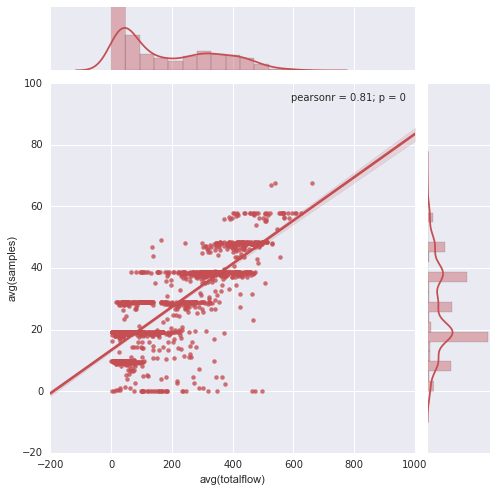

In [322]:
# precursor plot to see if a linear regression seems like it would be plausible for the data
sns.set(style="darkgrid", color_codes=True)

g = sns.jointplot("avg(totalflow)", "avg(samples)", data=merged_result_avg, kind="reg", color="r", size=7)

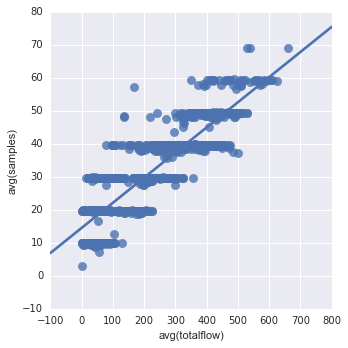

In [243]:
# using robust regression doesn't appear to give a different result for our dataset
sns.lmplot(x="avg(totalflow)", y="avg(samples)", data=merged_result_avg,
           robust=True, ci=None, scatter_kws={"s": 80});

# Determine feature importance
## Step1 convert categorical dimensions to numeric
## Step2 run through randomforest classifier to determine feature importance

In [401]:
# use label encoder to convert all non-numeric values into a numeric representation
clean_train = merged_result_avg_100.copy()
non_numeric = clean_train.columns.to_series().groupby(clean_train.dtypes).groups
print "non_numeric: %s" % non_numeric

# convert to categorical dimensions to numeric
number = LabelEncoder()
non_numeric_labels = {k.name: v for k, v in non_numeric.items()}['object']
for label in non_numeric_labels:
    clean_train[label] = number.fit_transform(clean_train[label].astype('str'))
non_numeric = clean_train.columns.to_series().groupby(clean_train.dtypes).groups
print "\nnon_numeric after clean: %s" % non_numeric

clean_train.head()

non_numeric: {dtype('O'): ['avg(lane8_avgspeed)', 'avg(lane8_flow)', 'Dir', 'State_PM', 'Type', 'Name', 'User_ID_2', 'User_ID_3', 'User_ID_4', 'file_date'], dtype('int64'): ['Station', '_c0', 'Unnamed: 0', 'Unnamed: 0.1', 'ID', 'Fwy', 'District', 'County', 'Lanes', 'User_ID_1'], dtype('float64'): ['avg(avgspeed)', 'avg(lane1_avgspeed)', 'avg(lane1_flow)', 'avg(lane2_avgspeed)', 'avg(lane2_flow)', 'avg(lane3_avgspeed)', 'avg(lane3_flow)', 'avg(lane4_avgspeed)', 'avg(lane4_flow)', 'avg(lane5_avgspeed)', 'avg(lane5_flow)', 'avg(lane6_avgspeed)', 'avg(lane6_flow)', 'avg(lane7_avgspeed)', 'avg(lane7_flow)', 'avg(perc_observed)', 'avg(samples)', 'avg(totalflow)', 'City', 'Abs_PM', 'Latitude', 'Longitude', 'Length', 'elevation']}

non_numeric after clean: {dtype('int64'): ['Station', 'avg(lane8_avgspeed)', 'avg(lane8_flow)', '_c0', 'Unnamed: 0', 'Unnamed: 0.1', 'ID', 'Fwy', 'Dir', 'District', 'County', 'State_PM', 'Type', 'Lanes', 'Name', 'User_ID_1', 'User_ID_2', 'User_ID_3', 'User_ID_4', 'f

,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),avg(lane4_avgspeed),avg(lane4_flow),...,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
0,1108418,NaN,NaN,34.104241,NaN,8.051231,NaN,NaN,NaN,NaN,...,NaN,6,2,205,10512,0,0,0,9,46.761951
1,1108598,NaN,NaN,13.661365,NaN,15.291281,NaN,NaN,NaN,NaN,...,NaN,6,2,316,12602,0,0,0,9,183.335815
2,1114817,65.420123,70.247056,100.819969,67.068156,105.283492,63.908823,86.117006,58.945552,80.680488,...,0.303,5,4,698,3059,0,0,0,9,5.323312
3,1115517,66.718042,73.345410,75.098410,70.190123,89.131014,65.249489,107.169521,63.487130,121.113515,...,0.480,5,5,854,10309,0,0,0,9,7.147941
4,1120419,57.438984,57.438984,130.177665,NaN,NaN,NaN,NaN,NaN,NaN,...,2.841,4,1,718,43207,0,0,0,9,33.287594


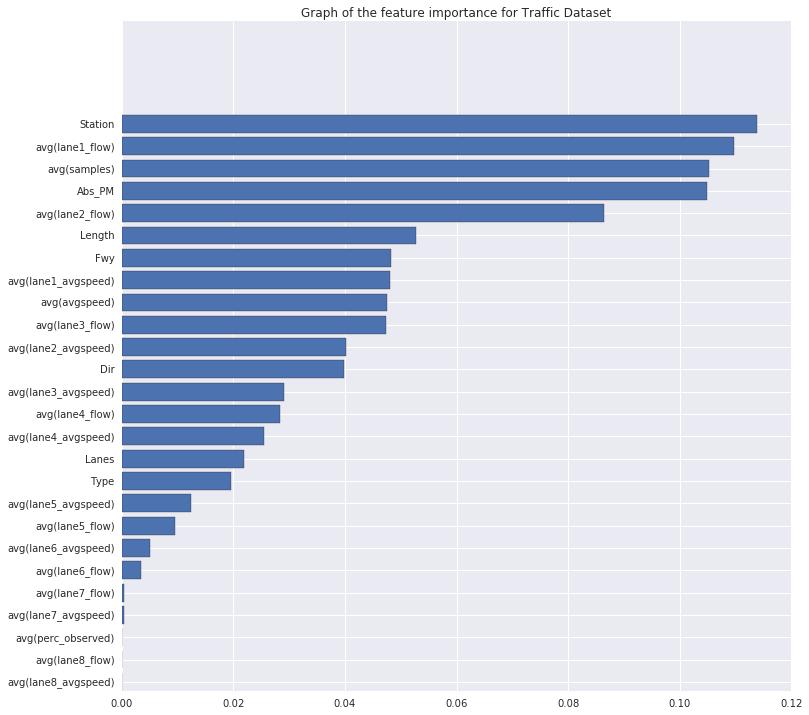

In [418]:
# determine the importance features
clean_train = clean_train.fillna(0)
for col in clean_train.columns:
    clean_train[col] = pd.to_numeric(clean_train[col])
    
y_100 = clean_train['avg(totalflow)']
train_columns = [u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'Fwy', u'Dir', u'Abs_PM',
       u'Length', u'Type', u'Lanes']
X_train, X_test, y_train, y_test = train_test_split(
    clean_train[train_columns], y_100, test_size=0.25, random_state=42)

model = sklearn.ensemble.RandomForestClassifier(random_state=42)

# model complained about having an unknown label until the conversion was done
y_train = np.asarray(y_train, dtype="|S6")
model.fit(X_train, y_train)
data = sorted(zip(train_columns, model.feature_importances_), key=lambda x: x[1])
data_arr = np.array(data)

index = np.arange(len(data_arr[:, 0]))
plt.figure(figsize=(12, 12))
ans = plt.barh(index, data_arr[:, 1])
ans = plt.yticks(index + .4, data_arr[:, 0])
ans = plt.title('Graph of the feature importance for Traffic Dataset')

From the chart above we can see that the Station, avg(lane1_flow), avg(samples), Abs_PM, and avg(lane2_flow) are the most important features. Now we can use this information to see which of these leads to the strongest model.

In [419]:
merged_result_avg.columns

Index([u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)', u'_c0',
       u'Unnamed: 0', u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District',
       u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude',
       u'Length', u'Type', u'Lanes', u'Name', u'User_ID_1', u'User_ID_2',
       u'User_ID_3', u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

After some experimentation it was determined that the strongest, smallest combination of columns is:
avg(lane1_flow), avg(samples) and avg(lane2_flow)

In [498]:
columns = ['avg(lane1_flow)', 'avg(samples)', 'avg(lane2_flow)']

In [540]:
lr = linear_model.LinearRegression()
main_line_100 = merged_result_avg_100[merged_result_avg_100.Type == 'ML'].fillna(0)
y_100 = main_line_100['avg(totalflow)']
X_100 = main_line_100[columns]

# split the data between train and test
X_train_100, X_test_100, y_train_100, y_test_100 = train_test_split(
    X_100, y_100, test_size=0.75, random_state=42)
model_100 = lr.fit(X_train_100, y_train_100)
predictions_100 = model_100.predict(X_test_100)
scores_100 = model_100.score(X_test_100, y_test_100)
scores_100

0.90849911794500238

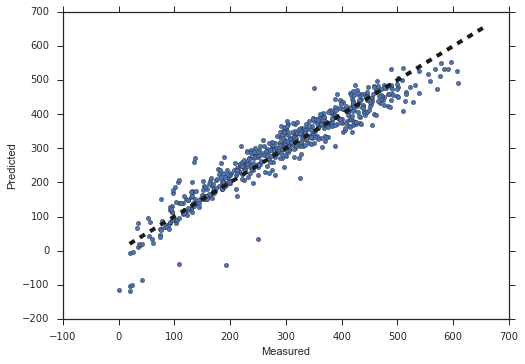

In [541]:
fig, ax = plt.subplots()
ax.scatter(y_test_100, predictions_100)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [542]:
# compare the same columns via a model including the imputed data by caltrans
lr = linear_model.LinearRegression()
main_line = merged_result_avg[merged_result_avg.Type == 'ML'].fillna(0)
y = main_line['avg(totalflow)']
X = main_line[columns]

# split the data between train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.75, random_state=42)
model = lr.fit(X_train, y_train)
predictions = model.predict(X_test)
scores = model.score(X_test, y_test)
scores

0.78576395808784083

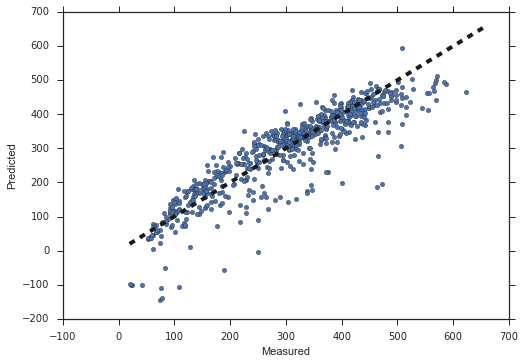

In [543]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Both models have an issue with predicting negative flow. Since negative flow makes no sense this will be adjusted to 0, if this is successful.

In [544]:
# compare the model without imputed data to the imputed values
bad_main_line = merged_result_avg[(merged_result_avg['avg(perc_observed)'] == 0) & (merged_result_avg.Type == 'ML')][
    columns + ['avg(totalflow)', 'Station']
]
bad_main_line

,avg(lane1_flow),avg(samples),avg(lane2_flow),avg(totalflow),Station
126,NaN,0.000000,93.299065,246.693750,1123089
154,52.712832,0.000000,66.039334,118.752166,1119060
216,98.020976,0.000000,107.975148,495.554492,1126156
281,72.942099,0.000000,84.314675,157.256773,1119179
313,52.856828,0.000000,67.110576,119.967405,1119059
350,82.184156,0.000000,85.399395,167.583551,1113072
373,54.128456,19.340531,68.224728,122.353184,1119042
446,51.666451,0.000000,66.449399,177.296979,1122781
447,74.586149,0.000000,86.480791,236.310249,1122942
494,77.159813,0.000000,87.861230,165.021042,1122991


In [545]:
# avg_flow = main_line_100['avg(totalflow)'].mean()
bad_line_input = bad_main_line[columns].fillna(0)
predict_bad_100 = model_100.predict(bad_line_input)
predict_bad = model.predict(bad_line_input)

In [546]:
print predictions_100[0:5]
print predictions[0:5]
print bad_main_line[['avg(totalflow)']][0:5]

[ 378.51565758   82.10868453  364.58679129  406.85245041  381.37621473]
[ 380.65837116  148.31787707  253.03817948  349.93413468  285.82779137]
     avg(totalflow)
126      246.693750
154      118.752166
216      495.554492
281      157.256773
313      119.967405


In [547]:
bad_main_line.head()

,avg(lane1_flow),avg(samples),avg(lane2_flow),avg(totalflow),Station
126,NaN,0.0,93.299065,246.693750,1123089
154,52.712832,0.0,66.039334,118.752166,1119060
216,98.020976,0.0,107.975148,495.554492,1126156
281,72.942099,0.0,84.314675,157.256773,1119179
313,52.856828,0.0,67.110576,119.967405,1119059


In [548]:
merged_result_avg.columns

Index([u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)', u'_c0',
       u'Unnamed: 0', u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District',
       u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude',
       u'Length', u'Type', u'Lanes', u'Name', u'User_ID_1', u'User_ID_2',
       u'User_ID_3', u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

## Test new imputed approach

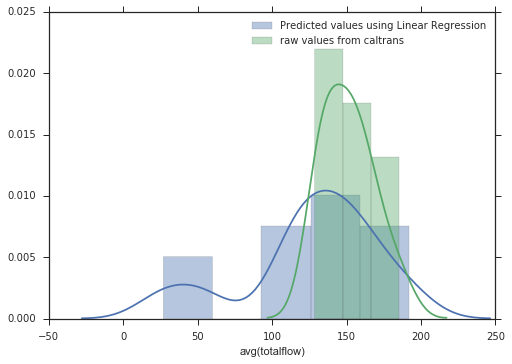

In [524]:
# Let's look at just the W_56
verify_56 = merged_result_avg[
    (merged_result_avg.Type == 'ML') & (merged_result_avg.Dir == 'W') & (merged_result_avg.Fwy == 56)][columns]
raw_56 = merged_result_avg[
    (merged_result_avg.Type == 'ML') & (merged_result_avg.Dir == 'W') & (merged_result_avg.Fwy == 56)][
    ['avg(totalflow)']]
predict_with_imputed = model_100.predict(verify_56)
to_plot = pd.Series(predict_with_imputed, name='avg(totalflow)')
ax = sns.distplot(to_plot, label='Predicted values using Linear Regression')
ax = sns.distplot(raw_56, ax=ax, label='raw values from caltrans')
plt.legend()

In [551]:
merged_result_avg.columns

Index([u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)', u'_c0',
       u'Unnamed: 0', u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District',
       u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude',
       u'Length', u'Type', u'Lanes', u'Name', u'User_ID_1', u'User_ID_2',
       u'User_ID_3', u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

In [564]:
W_56 = merged_result_avg_100[
    (merged_result_avg_100.Type == 'ML') & (merged_result_avg_100.Dir == 'W') & (merged_result_avg_100.Fwy == 56)]
W_56[['Station', 'Abs_PM', 'avg(perc_observed)', 'avg(totalflow)'] + columns].sort_values(
    by='Abs_PM')

,Station,Abs_PM,avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(samples),avg(lane2_flow)
845,1108743,0.881,100.0,169.793903,70.592726,19.752777,99.201177
155,1108745,1.861,100.0,149.996062,74.368454,19.750775,75.627608
1343,1113720,2.909,100.0,139.494396,70.147627,19.754950,69.346768
882,1113771,4.519,100.0,154.590137,79.855364,19.745703,74.734774
874,1113760,5.948,100.0,130.273411,69.318198,19.754806,60.955212
665,1125219,6.175,100.0,129.411061,68.685790,19.756935,60.725272
214,1125575,7.661,100.0,125.649981,64.198317,19.755641,61.451664
849,1125546,8.565,100.0,138.233397,67.247084,19.756190,70.986312
98,1125531,9.302,100.0,158.144638,65.109398,19.752533,93.035240


In [575]:
W_56 = merged_result_avg_100[
    (merged_result_avg_100.Type == 'ML') & (merged_result_avg_100.Dir == 'W') & (merged_result_avg_100.Fwy == 56)]
W_56_model = model_100.fit(W_56[columns], W_56['avg(totalflow)'])
W_56[columns + ['avg(totalflow)', 'Station', 'Abs_PM']].sort_values(by='Abs_PM')

,avg(lane1_flow),avg(samples),avg(lane2_flow),avg(totalflow),Station,Abs_PM
845,70.592726,19.752777,99.201177,169.793903,1108743,0.881
155,74.368454,19.750775,75.627608,149.996062,1108745,1.861
1343,70.147627,19.754950,69.346768,139.494396,1113720,2.909
882,79.855364,19.745703,74.734774,154.590137,1113771,4.519
874,69.318198,19.754806,60.955212,130.273411,1113760,5.948
665,68.685790,19.756935,60.725272,129.411061,1125219,6.175
214,64.198317,19.755641,61.451664,125.649981,1125575,7.661
849,67.247084,19.756190,70.986312,138.233397,1125546,8.565
98,65.109398,19.752533,93.035240,158.144638,1125531,9.302


In [573]:
bad_values = merged_result_avg[
    (merged_result_avg.Type == 'ML') & (merged_result_avg.Dir == 'W') & (merged_result_avg.Fwy == 56) &
    (merged_result_avg['avg(perc_observed)'] <= 90)]
bad_values = bad_values[['Station', 'Abs_PM', 'avg(perc_observed)', 'avg(totalflow)'] + columns].sort_values(
    by='Abs_PM')
bad_values

,Station,Abs_PM,avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(samples),avg(lane2_flow)
780,1125631,3.190,48.928085,151.770741,68.551494,19.333715,83.219247
962,1113760,5.948,89.445245,133.725991,70.604207,17.946276,63.121785
350,1113072,7.885,0.000000,167.583551,82.184156,0.000000,85.399395
904,1122983,9.712,0.000000,185.492642,88.259937,0.000000,97.232705


In [574]:
W_56_predict = W_56_model.predict(bad_values[columns])
bad_values.index = range(0, len(bad_values))

pd.concat([bad_values, pd.DataFrame({'predicted': W_56_predict})], axis=1)

,Station,Abs_PM,avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(samples),avg(lane2_flow),predicted
0,1125631,3.190,48.928085,151.770741,68.551494,19.333715,83.219247,151.770741
1,1113760,5.948,89.445245,133.725991,70.604207,17.946276,63.121785,133.725991
2,1113072,7.885,0.000000,167.583551,82.184156,0.000000,85.399395,167.583551
3,1122983,9.712,0.000000,185.492642,88.259937,0.000000,97.232705,185.492642


## Imputed calc results
As we can see the results are the same as what has been provided by caltrans. So we haven't improved the dataset.

# Density (need to use this)
Since the analysis of the flow through the freeway system doesn't line up well it seems like this is the incorrect parameter to our outlier detection. Instead let's move to density which should address the issues in the variance of the flow rates from the ramps to the main line.

Density = AbsDist * Flow / (Speed / 12)
Since Speed is in Miles per hour and Flow is vehciles per 5 min, we need to normalize the units

## Start with 56 W

In [318]:
W56 = merged_result_avg_100[(merged_result_avg_100.Dir == 'W') & (merged_result_avg_100.Fwy == 56) &
                            (merged_result_avg_100.Type == 'ML')]
merged_columns = [u'Station', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)', u'avg(perc_observed)', 'avg(avgspeed)',
       u'avg(samples)', u'avg(totalflow)', u'Fwy', u'Dir', u'Abs_PM', u'Latitude', u'Longitude', u'Length',
       u'Type', u'Lanes', u'Name']
merged_data = pd.merge(W56[merged_columns], freeway_vectors['56_W'][['ID', 'order', 'distance']],
                       how='left', left_on='Station', right_on='ID')
merged_data['density'] = (merged_data['distance'] * merged_data['avg(totalflow)']) / merged_data['avg(avgspeed)']
merged_data[['Station', 'order', 'density']].sort_values(by='order')

,Station,order,density
4,1108743,0,2.406845
1,1108745,1,2.335829
8,1113720,2,2.347812
7,1113771,4,3.280595
6,1113760,5,2.935464
3,1125219,6,0.456556
2,1125575,7,2.887269
5,1125546,9,1.456507
0,1125531,10,1.854467


In [319]:
# scale density to all freeways
freeway_density = []
for freeway_key in freeway_vectors:
    fwy_num, fwy_dir = freeway_key.split('_')
    freeway_data = merged_result_avg_100[(merged_result_avg_100.Dir == fwy_dir) & 
                                         (merged_result_avg_100.Fwy == int(fwy_num)) &
                                         (merged_result_avg_100.Type == 'ML')]
    merged_columns = [u'Station', u'avg(lane1_avgspeed)',
           u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
           u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
           u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
           u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
           u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)', u'avg(perc_observed)', 'avg(avgspeed)',
           u'avg(samples)', u'avg(totalflow)', u'Fwy', u'Dir', u'Abs_PM', u'Latitude', u'Longitude', u'Length',
           u'Type', u'Lanes', u'Name']
    merged_data = pd.merge(freeway_data[merged_columns], freeway_vectors[freeway_key][['ID', 'order', 'distance']],
                           how='left', left_on='Station', right_on='ID')
    merged_data['density'] = (merged_data['distance'] * merged_data['avg(totalflow)']) / merged_data['avg(avgspeed)']
    freeway_density.append(merged_data[['Station', 'Fwy', 'Dir', 'Lanes', 'order', 'density']].sort_values(by='order'))

In [320]:
results = pd.concat(freeway_density).sort_values(by=['Fwy', 'Dir', 'order'])

In [321]:
results[(results.order == 0) | (results.order == 1)]

,Station,Fwy,Dir,Lanes,order,density
43,1114091,5,N,6,0.0,0.145653
3,1118333,5,N,4,1.0,1.251174
5,1118326,5,S,4,0.0,1.675241
96,1114708,5,S,5,1.0,0.292412
28,1111514,8,E,2,0.0,0.681831
30,1108728,8,E,2,1.0,0.646862
14,1114546,8,W,4,0.0,5.959346
27,1116574,8,W,2,1.0,1.505008
45,1119689,15,N,4,0.0,2.588592
24,1119694,15,N,3,1.0,1.364309


## Outlier Detection

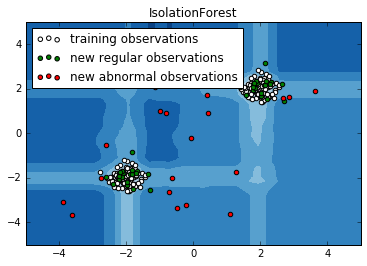

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble.iforest import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

In [ ]:
# data.printSchema()